# Given a list of object ids, extracts their avros to get pixel coordinates of their detections, plot their coordinates, stamps and overplot in aladin

**WARNING**: This notebook will be replaced by a version using the new database, API and client.

Francisco Förster, 2020

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import ipyaladin as ipyal # see installation instructions here: https://github.com/cds-astro/ipyaladin
from astropy.table import Table, Column
from astropy import coordinates
import numpy as np

In [2]:
import requests

In [3]:
from alerce.api import AlerceAPI
client = AlerceAPI()

# The list of candidates

In [4]:
oids = ["ZTF19adbtqgy", "ZTF20aacbijc", "ZTF20aaehjjm", "ZTF20aaebiae", "ZTF20aaejaax"]

# Check avro files for pixel position

In [5]:
df = []
for oid in oids:
    
    # get candid
    params = {"oid": oid}
    url = "https://ztf.alerce.online"
    r = requests.post(url = "%s/get_detections" % url, json = params)
    candid = r.json()["result"]["detections"][0]["candid"]
    
    # get avro
    params = {"oid": oid, "candid": candid}
    url = "http://avro.alerce.online"
    r = requests.get(url = "%s/get_avro_info" % url, params = params)
    response = r.json()
    
    # extract selected fields
    fields = ["jd", "ra", "dec", "xpos", "ypos", "rb", "drb"]
    df.append(pd.DataFrame(data = [[oid, candid] + [response['candidate'][field] for field in fields]],
                            columns=["oid", "candid", "jd", "ra", "dec", "xpos", "ypos", "rb", "drb"]))
df = pd.concat(df)
df.set_index("oid", inplace=True)
df

,candid,jd,ra,dec,xpos,ypos,rb,drb
oid,,,,,,,,
ZTF19adbtqgy,1092289313615015065,2.458847e+06,132.499845,70.311704,1682.025879,2919.749268,0.365714,0.999991
ZTF20aacbijc,1097444403615015104,2.458852e+06,132.511787,70.313686,1681.534546,2919.635254,0.395714,0.999998
ZTF20aaehjjm,1100451663615015164,2.458855e+06,132.511148,70.312382,1681.734741,2919.563477,0.421429,0.999996
ZTF20aaebiae,1100187173615015124,2.458855e+06,132.515880,70.292508,1681.752686,2919.568359,0.394286,1.000000
ZTF20aaejaax,1101179013615015179,2.458856e+06,132.521993,70.292265,1681.814941,2919.816895,0.641429,1.000000


# Plot positions

Text(0, 0.5, 'ypos')

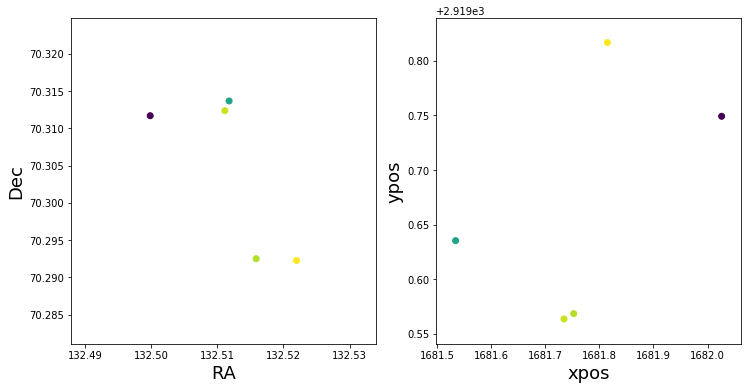

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
ax[0].scatter(df.ra, df.dec, c = df.jd)
ax[0].set_xlabel("RA", fontsize=18)
ax[0].set_ylabel("Dec", fontsize=18)
ax[1].scatter(df.xpos, df.ypos, c = df.jd)
ax[1].set_xlabel("xpos", fontsize=18)
ax[1].set_ylabel("ypos", fontsize=18)

# Show stamps

In [7]:
for oid in df.index:
    client.plot_stamp(oid)

# Display in Aladin

In [8]:
aladin= ipyal.Aladin(target='%s %s' % (df.iloc[0].ra, df.iloc[0].dec), fov=0.15, survey='P/PanSTARRS/DR1/color-z-zg-g')
aladin

Aladin(fov=0.15, options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'overlay_survey', 'o…

In [9]:
cand = Table.from_pandas(pd.DataFrame(
                data={"MAIN_ID": df.index.tolist(), "ra": df.ra.to_list(), "dec": df.dec.to_list()}))
aladin.add_table(cand)